In [2]:
import numpy as np
import sys
sys.path.append('../../lib/')
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from analysis import *
import pickle as pkl

In [3]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, \
    Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
import tensorflow
tensorflow.keras.utils.pydot = pyd

Read Data

In [6]:
data = pkl.load(open('../../Data/data.pkl', 'rb'))

X_input_train = data['X_input_train']
X_output_train = data['X_output_train']
X_input_test = data['X_input_test']
X_output_test = data['X_output_test']

x_trend_param = data['x_trend_param']
x_train_max = data['x_train_max']

In [7]:
# load model
from tensorflow.keras.models import load_model

file_path = '../../Results/LSTM/'
filename = 'model_forecasting_seq2seq_1000.h5'
model = load_model(file_path + filename)

Predict

In [23]:
def LSTM_model_prediction(model, X_input_train, X_input_test, x_train_max,
                          X_output_train, X_output_test):
    
    train_pred_detrend = model.predict(X_input_train[:, :, :1])*x_train_max[:2]
    test_pred_detrend = model.predict(X_input_test[:, :, :1])*x_train_max[:2]

    train_true_detrend = X_output_train[:, :, :1]*x_train_max[:2]
    test_true_detrend = X_output_test[:, :, :1]*x_train_max[:2]
    
    # combine with the index
    train_pred_detrend = np.concatenate([train_pred_detrend,
                                         np.expand_dims(X_output_train[:, :, 1],
                                                        axis=2)], axis=2)
    test_pred_detrend = np.concatenate([test_pred_detrend,
                                        np.expand_dims(X_output_test[:, :, 1],
                                                       axis=2)], axis=2)

    train_true_detrend = np.concatenate([train_true_detrend,
                                         np.expand_dims(X_output_train[:, :, 1],
                                                        axis=2)], axis=2)
    test_true_detrend = np.concatenate([test_true_detrend,
                                        np.expand_dims(X_output_test[:, :, 1],
                                                       axis=2)], axis=2)
    # recover trend
    data_final = dict()

    for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                    ['train_pred', 'train_true', 'test_pred', 'test_true']):
        dt_x = dt[:, :, 0] + dt[:, :, 1] * x_trend_param[0] + x_trend_param[1]
        data_final[lb] = np.expand_dims(dt_x, axis=2)    
    
    return data_final


In [24]:
data_final = LSTM_model_prediction(model, X_input_train, X_input_test, x_train_max,
                                   X_output_train, X_output_test)

In [25]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
25279.114942944452
maximum: train_true
25285.37453592877
maximum: test_pred
24979.473463211674
maximum: test_true
24948.27873213366


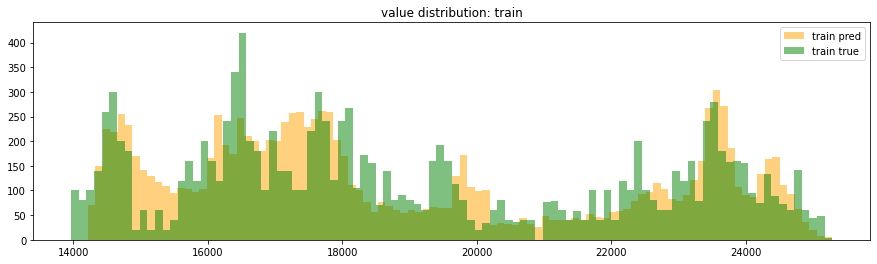

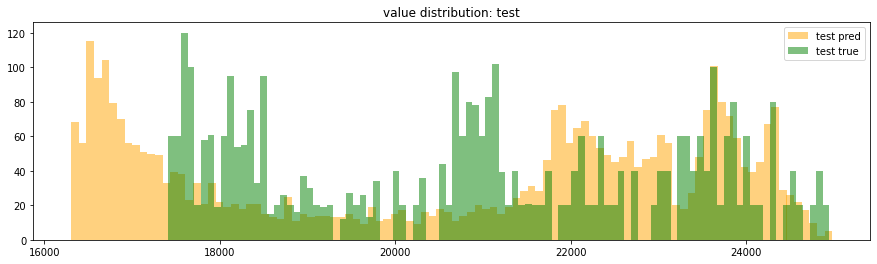

In [26]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

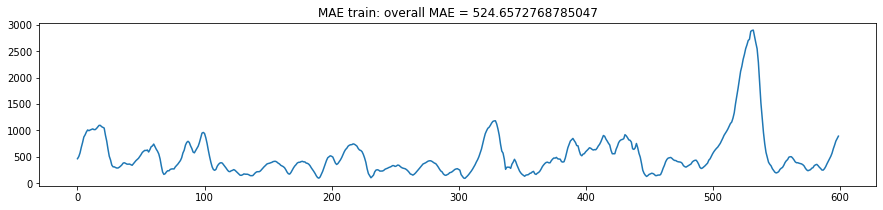

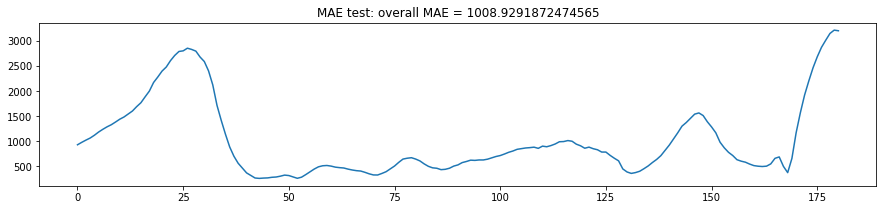

In [27]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

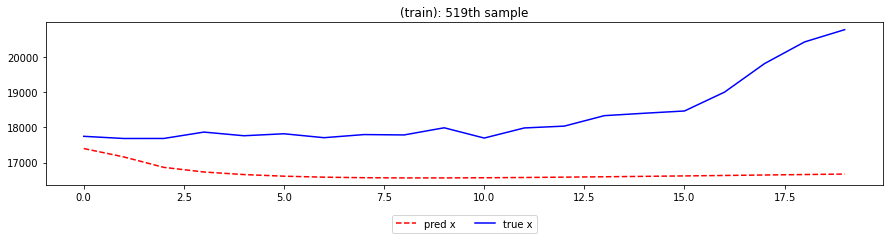

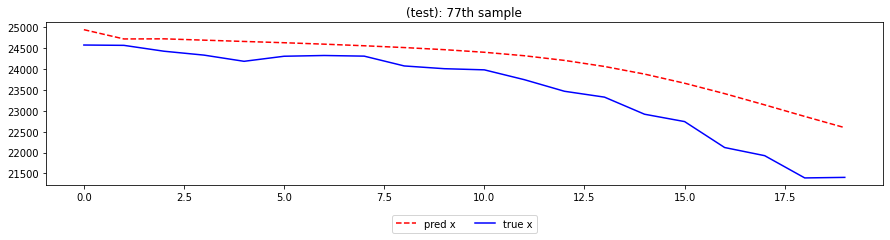

In [28]:
import random

for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))

    plt.figure(figsize=(15,3))
    plt.plot(data_final[lb+'_pred'][ith_sample, :, 0], linestyle='--', color='r', label='pred x')
    plt.plot(data_final[lb+'_true'][ith_sample, :, 0], linestyle='-', color='b', label='true x')
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

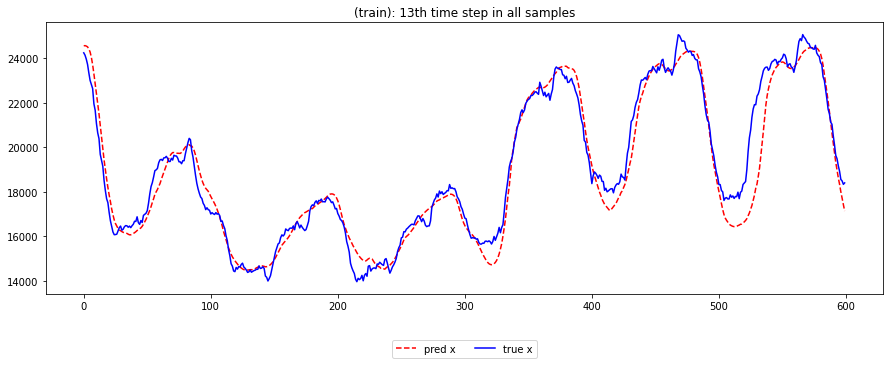

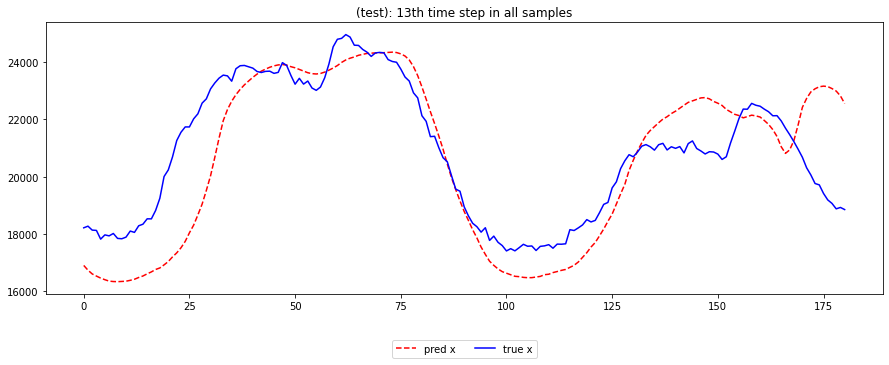

In [29]:
timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
for lb in ['train', 'test']:   
    plt.figure(figsize=(15, 5))
    plt.plot(data_final[lb+'_pred'][:, timestep, 0], linestyle='--', color='r', label='pred x')
    plt.plot(data_final[lb+'_true'][:, timestep, 0], linestyle='-', color='b', label='true x')
    plt.title('({}): {}th time step in all samples'.format(lb, timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

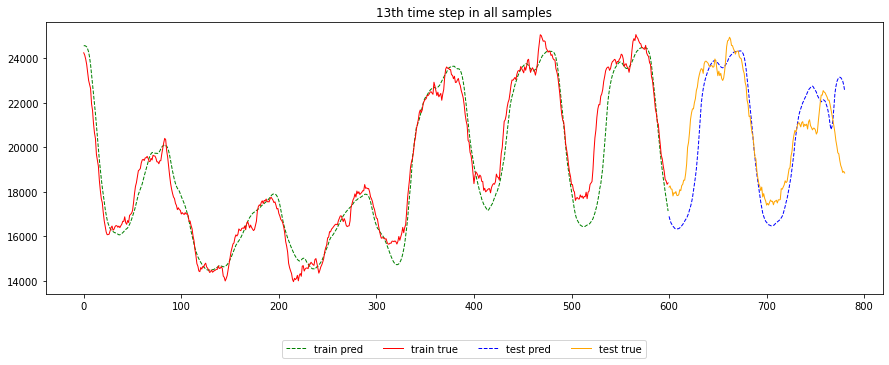

In [30]:
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]


labels = ['train', 'test']
variables = [train_start_t, test_start_t]
colors = [['green', 'red'], ['blue', 'orange']]

for lb, tm, clrs in zip(labels, variables, colors):
    n = data_final[f'{lb}_pred'].shape[0]
    plt.plot(range(tm, tm + n), 
             data_final[f'{lb}_pred'][:, timestep, 0], 
             linestyle='--', linewidth=1, color=clrs[0], label=f'{lb} pred')
    plt.plot(range(tm, tm + n), 
             data_final[f'{lb}_true'][:, timestep, 0], 
             linestyle='-', linewidth=1, color=clrs[1], label=f'{lb} true')
    
plt.title(f'{timestep}th time step in all samples')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=False, ncol=8)
plt.show()

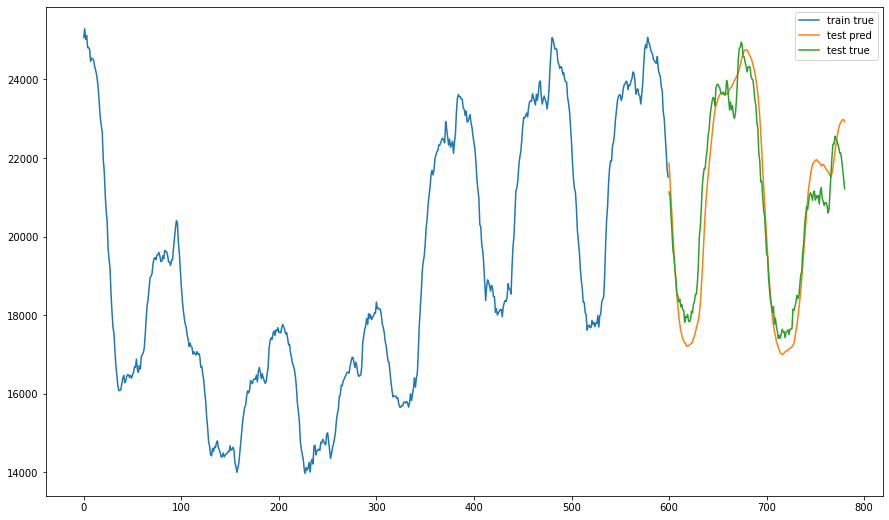

In [31]:
plt.figure(figsize=(15, 9))
i = 1
lentgh_train = len(data_final['train_pred'])
lentgh_test = len(data_final['test_pred'])

t = range(lentgh_train, lentgh_train+lentgh_test)
plt.plot(data_final['train_true'][:, i ,0], label='train true')
plt.plot(t, data_final['test_pred'][:, i ,0], label='test pred')
plt.plot(t, data_final['test_true'][:, i ,0], label='test true')
plt.legend()